<a href="https://colab.research.google.com/github/GUNTERMAXIMUS/covid-19predictCL/blob/master/covod_19_Global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
try:
  %tensorflow_version 2.x
except OSError:
  print(tf.__version__)
finally:
  import tensorflow as tf
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense, LSTM, Dropout
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  
  import requests as rq
  import io
  
  print(f'TF version: {tf.__version__}')
  
#  from google.colab import drive
#  drive.mount('/content/gdrive', force_remount = True, timeout_ms = 60000)


TF version: 2.2.0-rc2


In [0]:
url = 'https://raw.githubusercontent.com/GUNTERMAXIMUS/covid-19predictCL/master/covid_19_data.csv'

respond = rq.get(url).content

df_data = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7],
                      encoding = 'utf-8'
                      )

df_train = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7], 
                      encoding = 'utf-8'
                      )

In [14]:
#df = df_data[df_data['Country/Region'].str.contains('Chile')].dropna()
df = df_data
df_train.dropna()
print(df.isnull().any())
df.tail(10)

ObservationDate    False
Country/Region     False
Confirmed          False
Deaths             False
Recovered          False
dtype: bool


,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
12239,04/05/2020,US,2640.0,52.0,0.0
12240,04/05/2020,US,7825.0,336.0,0.0
12241,04/05/2020,US,324.0,3.0,0.0
12242,04/05/2020,Australia,453.0,3.0,92.0
12243,04/05/2020,US,2320.0,74.0,0.0
12244,04/05/2020,US,197.0,0.0,0.0
12245,04/05/2020,Mainland China,76.0,3.0,73.0
12246,04/05/2020,Canada,6.0,0.0,0.0
12247,04/05/2020,Mainland China,184.0,2.0,172.0
12248,04/05/2020,Mainland China,1263.0,1.0,1230.0


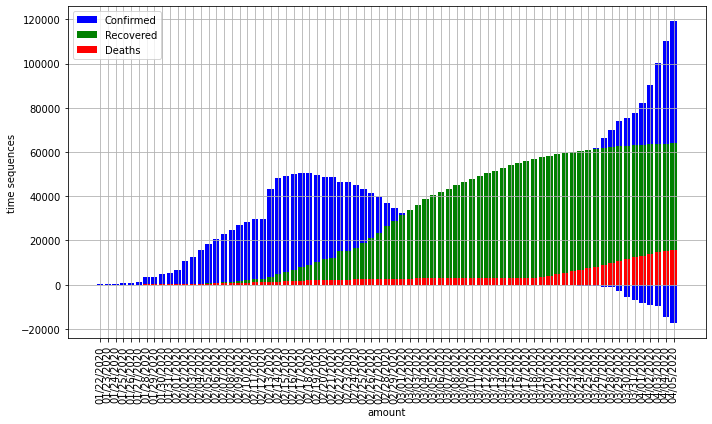

In [15]:
x = df.ObservationDate
y = (df.Confirmed) - (df.Recovered + df.Deaths)
#y = df.Confirmed

plt.figure(figsize = (10, 6))
plt.bar(x, y, label = 'Confirmed', color = 'blue')
plt.bar(x, df.Recovered, label = 'Recovered', color = 'green')
plt.bar(x, df.Deaths, label = 'Deaths', color = 'red')
#plt.stackplot(x, df.Confirmed, df.Recovered, df.Deaths)
plt.xlabel('amount')
plt.ylabel('time sequences')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 'vertical')
plt.tight_layout()
plt.grid(True)

plt.show()

In [0]:
dates = df.ObservationDate
confirmed = np.array([int(i) for i in y]).reshape(-1, 1)
deaths = np.array([int(i) for i in df.Deaths]).reshape(-1, 1)
recovered = np.array([int(i) for i in df.Recovered]).reshape(-1, 1)
mortality_rate = np.array(df['Deaths'].tail(1) / df['Confirmed'].tail(1).sum()).reshape(-1, 1)

confirmed_total = df.Confirmed.tail(1)

days = np.array([i for i in range(len(dates))]).reshape(-1, 1)
deaths_total = np.array(df.Deaths.tail(1)).reshape(-1, 1)
recovered_total = np.array(df.Recovered.tail(1)).reshape(-1, 1)

In [17]:
mortality_rate = ((df.Deaths.tail(1) / df.Confirmed.tail(1)).sum()) * 100
print(f'Mortality rate: {mortality_rate} %')

Mortality rate: 0.0791765637371338 %


In [0]:
days_future = 30
future_forecast_days = np.array([i for i in range(len(dates) + days_future)]).reshape(-1, 1)
adjusted_dates = future_forecast_days[:-30]

In [0]:
# convert integers into date time for visualization
import datetime
start_date = datetime.datetime.strptime('03/03/2020', '%m/%d/%Y')
future_forecaste_dates = []

for i in range(len(future_forecast_days)):
  future_forecaste_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import operator

In [0]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv=3, return_train_score=True, 
                                n_jobs=-1, n_iter=40, verbose=1)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days, confirmed, test_size=0.15, shuffle=False)

In [11]:
svm_search.fit(X_train_confirmed, y_train_confirmed.ravel())

KeyboardInterrupt: ignored

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [0]:
svm_search.best_params_

In [0]:
svm_confirmed = svm_search.best_estimator_
svm_prediction = svm_confirmed.predict(future_forecast_days)

print(svm_confirmed)
print(svm_prediction)

In [0]:
plt.figure(figsize = (10, 6))
plt.plot(adjusted_dates, y)
plt.plot(future_forecast_days, svm_prediction, linestyle='dashed', color='red')
plt.xlabel('Days | 30 days prediction')
plt.ylabel('Cases')
plt.legend(['Confirmed cases', f'SVM predictions | MAX: {int(round(svm_prediction[-1]))}'])
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [0]:
plt.figure(figsize = (10, 6))
plt.plot(adjusted_dates, y)
plt.plot(future_forecast_days, svm_prediction, linestyle='dashed', color='red')
plt.xlabel('Days | 30 days prediction')
plt.ylabel('Cases')
plt.legend(['Confirmed cases', f'SVM predictions | MAX: {int(round(svm_prediction[-1]))}'])
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()